# 1. Synthetic Dataset Generation

## Type Definitions

Following are some useful type definitions to avoid verbose code later on

In [68]:
from typing import Dict
import networkx as nx

# Type definitions
Ged = int
HistoryKey = int
HistoryValue = tuple[nx.Graph, Ged]
HistoryEntry = tuple[HistoryKey, HistoryValue]
History = Dict[HistoryKey, HistoryValue]

## RandomGraphGenerator

RandomGraphGenerator is a class used to randomly generate graphs with some input parameters allowing for some customization

In [58]:
from random import randint
from random import uniform
from random import choice
import networkx as nx

class RandomGraphGenerator():
    """RandomGraphGenerator can be used to generate random graph with parameters in input.\n
    The way it does so ensures that there are no isolates nodes (there should be at least 2 nodes in the generated graph)"""
    def generate_random_ER_graph(self, nmin=2, nmax=10, pmin=0.2, pmax=1):
        """Erdős-Rényi graph generation.\n
        Parameters:
        1. nmin, min number of nodes: >= 2
        2. nmax, max number of nodes: >= nmin
        3. pmin, min probability for edge creation: >= 0.01
        4. pmax, max probability for edge creation: <= 1
        """
        n  = randint(nmin, nmax) # Number of nodes
        p = uniform(pmin, pmax) # Probability for edge creation
        G = nx.gnp_random_graph(n, p, seed=None, directed=False)
        return self._make_connected(G)

    def generate_random_BA_graph(self, nmin=2, nmax=10):
        """Erdős-Rényi graph generation.\n
        Parameters:
        1. nmin, min number of nodes: nmin >= 2
        2. nmax, max number of nodes: >= nmin
        """
        n  = randint(nmin, nmax) # Number of nodes
        m = randint(1, n-1) # Number of edges to attach from a new node to existing nodes,
        if not (m >= 1 and m < n):
            raise Exception(f"m >= 1 and m < n", f"m={m}", f"n={n}")
        G = nx.barabasi_albert_graph(n, m, seed=None, initial_graph=None)
        return self._make_connected(G)
    
    def _make_connected(self, G : nx.Graph):
        for node in list(nx.isolates(G)):
            target_node = choice([n for n in G.nodes() if n != node])
            G.add_edge(node, target_node)
        return G

## Consecutor Archetype

### Consecutor

Consecutor is an abstract class which defines the prototypes to generate a graph G' starting from G

In [59]:
from abc import ABC, abstractmethod
import networkx as nx
from typing import List
from random import randint
from random import random
from copy import deepcopy

class UnprocessableError(Exception):
    """Error raised when no further process can be applied (useful in some Consecutor)"""
    pass

class Consecutor(ABC):
    """Abstract Consecutor with base utility methods ready for the concrete Consecutor.
    \nUsed to generate a Graph G' from G."""
    def next(self, G : nx.Graph) -> HistoryValue:
        """Return a tuple with a new graph G' and the distance from G (can be 0)"""
        if not self._is_processable(G):
            raise UnprocessableError()
        copy = deepcopy(G)
        rand = random()
        return self._next(copy, rand)
    
    @abstractmethod
    def _next(self, G : nx.Graph, rand : float) -> HistoryValue:
        """Actual next logic from concrete classes"""
        raise NotImplementedError()
    
    def _is_processable(self, G : nx.Graph) -> bool:
        """Whether you can make a 'next' on graph G"""
        return len(self._nodes(G)) > 0
    
    def _nodes(self, G : nx.Graph) -> List[int]:
        """Return the list of nodes of the graph G"""
        return list(G.nodes)
    
    def _edges(self, G : nx.Graph) -> List[tuple[int, int]]:
        """Return the list of edges of the graph G"""
        return list(G.edges)
    
    def _rand_obj_list(self, l : List) -> object | None:
        """Return a random object in list if not empty else None"""
        return l[randint(0, len(l) - 1)] if len(l) > 0 else None
    
    def _new_node(self, G : nx.Graph) -> int:
        """Return a new node for the graph G (biggest indexed node + 1)"""
        return (self._nodes(G)[-1] + 1) if len(self._nodes(G)) > 0 else 0
    
    def _rand_node(self, G : nx.Graph) -> int | None:
        """Return a random existing node of G if any else None"""
        return self._rand_obj_list(self._nodes(G))
    
    def _new_edge(self, G : nx.Graph) -> tuple[int, int] | None:
        """Return a new edgre for the graph G if not fully-connected else None"""
        return self._rand_obj_list(list(nx.non_edges(G)))
    
    def _rand_edge(self, G : nx.Graph) -> tuple[int, int] | None:
        """Return a random existing edge of G if any else None"""
        return self._rand_obj_list(self._edges(G))

### Incremental Consecutor

IncrementalConsecutor is a class that generates G' starting from G by adding something to it

In [60]:
class IncrementalConsecutor(Consecutor):
    """IncrementalConsecutor add nodes and edges. The way it does so ensures there are no isolates at any moment."""
    def _next(self, G : nx.Graph, rand : float) -> HistoryValue:
        if rand <= 0.33:
            return self.__add_node_and_edges(G)
        else:
            return self.__add_edge(G)
    
    def __add_node_and_edges(self, G : nx.Graph) -> HistoryValue:
        """Add a new node and k edges from the new node to random nodes"""
        new_node = super()._new_node(G)
        G.add_node(new_node)
        nodes = super()._nodes(G)
        k = randint(1, len(nodes) - 1)
        choices = list(filter(lambda n : n != new_node, nodes))
        for _ in range(0, k):
            target = super()._rand_obj_list(choices)
            G.add_edge(new_node, target)
            choices.remove(target)
        return G, (1+k)
            
    def __add_edge(self, G : nx.Graph) -> HistoryValue:
        """Add a new edge if not fully connected"""
        new_edge = super()._new_edge(G)
        if new_edge is None:
            return G, 0
        G.add_edge(*new_edge)
        return G, 1
        

### DecrementalConsecutor

DecrementalConsecutor is a class that generates G' starting from G by removing something from it

In [61]:
class DecrementalConsecutor(Consecutor):
    """DecrementalConsecutor removes nodes and edges, after any atomic operation it also removes isolated nodes.
    \nThis is due to how data is stored (edge adj matrix which drops isolates informations)."""
    def _next(self, G : nx.Graph, rand : float) -> HistoryValue:
        if rand <= 0.33:
            return self._remove_edge(G)
        else:
            return self._remove_node_and_edges(G)
        
    def _remove_node_and_edges(self, G : nx.Graph) -> HistoryValue:
        """Remove a random node along with its edges, if this causes a node to be isolated it is removed aswell"""
        rvm_node = self._rand_node(G)
        if rvm_node is None:
            return G, 0
        degree = G.degree(rvm_node)
        G.remove_node(rvm_node)
        isolated = list(nx.isolates(G))
        G.remove_nodes_from(isolated)
        return G, (1+degree+len(isolated))
            
    def _remove_edge(self, G : nx.Graph) -> HistoryValue:
        """Remove a random edge if there are any, if this causes a node to be isolated it is removed aswell"""
        rvm_edge = self._rand_edge(G)
        if rvm_edge is None:
            return G, 0
        G.remove_edge(*rvm_edge)
        isolated = list(nx.isolates(G))
        G.remove_nodes_from(isolated)
        return G, (1+len(isolated))
        

## ConsecutorExecutor

ConsecutorExecutor is a class that manages that execution of a concatenations of generations of new graphs by exploiting Consecutor class

In [62]:
from typing import Callable

class ConsecutorExecutor():
    """ConsecutorExecutor can be used to execute steps consecutions starting from a graph G"""
    def __init__(self, consecutor: Consecutor):
        self.consecutor = consecutor
    
    def execute(self, 
                G : nx.Graph, 
                steps = 100, 
                stopper : Callable[[nx.Graph], bool] = None,
                skip_zero_ged = True,
                ) -> History :
        """Perform steps attempts to modify graph G.
        Parameters:
        1. G, the graph where to start from
        2. steps, the number of atomic modifications
        3. stopper, an early custom stopping function
        4. skip_zero_ged, a Consecutor may return a G' with ged 0 w.r.t. G
        Returns a dict representing the history of graph generations with edit distance from previous graph.
        """
        history = {}
        history[-1] = (G, 0)
        for i in range(0, steps):
            try:
                G, ged = self.consecutor.next(G)  # Generation and update G
            except UnprocessableError:
                break
            if ged != 0 or not skip_zero_ged: # Save only when necessary
                history[i] = (G, ged)
            if stopper is not None and stopper(G): # Check if stopping condition applies
                break
        return history

## Plotting Functions

Just two functions used together to either plot two graphs side by side or to plot a series of graphs side by side by an history

In [63]:
import matplotlib.pyplot as plt

def plot_graphs_sbs(g1 : nx.Graph, g2 : nx.Graph):
    """Utility function to plot two graphs side by side"""
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    nx.draw(g1, with_labels=True, font_weight='bold', ax=axes[0])
    nx.draw(g2, with_labels=True, font_weight='bold', ax=axes[1])
    plt.tight_layout()
    plt.show()

def plot_cons_hist_entries(history: History, stop=None):
    """Utility function to plot entries of history in a consecutive manner"""
    entries = list(history.items())
    for i,e in enumerate(entries):
        n = entries[i+1]
        plot_graphs_sbs(e[1][0], n[1][0])
        if stop is not None and i+1 == stop:
            break
        if i+1 == len(entries) - 1:
            break 

## HistoryUtilities

HistoryUtilities is a class that provides useful functions for history datatype.

In [69]:
import pandas as pd
from itertools import combinations
from json import dump

class HistoryUtilities():
    """HistoryUtilities is responsible for providing common history utilities functions."""
        
    def build_combinations_df(self, history : History):
        """Function that generate a dataframe out from history"""
        entries = list(history.items())
        all_combs = list(combinations(entries, 2))
        df = pd.DataFrame({
            "graph_1": list(map(lambda c : list(c[0][1][0].edges), all_combs)),
            "graph_2": list(map(lambda c : list(c[1][1][0].edges), all_combs)),
            "ged": list(map(lambda c : self.calculate_ged_comb(history, c), all_combs)),
        })
        return df
        
    def assert_geds(self, history : History):
        """Checks for every combination of history the real ged distance"""
        all_entries = history.items()
        all_combinations = list(combinations(all_entries, 2))
        for comb in all_combinations:
            g1 = comb[0][1][0]
            g2 = comb[1][1][0]
            r = nx.graph_edit_distance(g1, g2)
            e = self.calculate_ged_comb(history, comb)
            assert r == e
            
    def calculate_ged_comb(self, history : History, comb : tuple[HistoryEntry, HistoryEntry]):
        """Returns the artificial ged distance given an entry combination"""
        delimiters = [comb[0][0], comb[1][0]]
        delimiters.sort()
        min, max = delimiters[0], delimiters[1]
        sum = 0
        for entry in history.items():
            key = entry[0]
            value = entry[1]
            if min < key <= max:
                sum += value[1]
            if key > max:
                break
        return sum
        

## Dataset Generation Worflow

- We start from a graph randomly generated called start
- We define the a 'Consecutor' and 'ConsecutorExecutor'
- We use the latter to generate an history of changes
- We use HistoryUtilities to generate a df from the history combinations
- We save our df to disk

### Incremental Dataset Generation Example

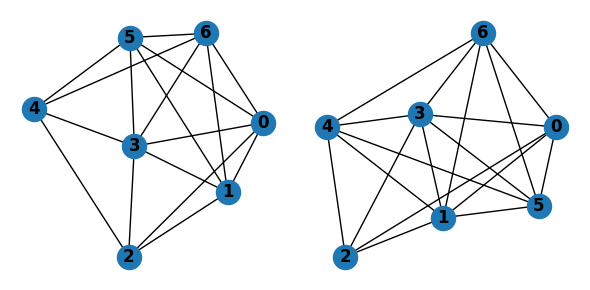

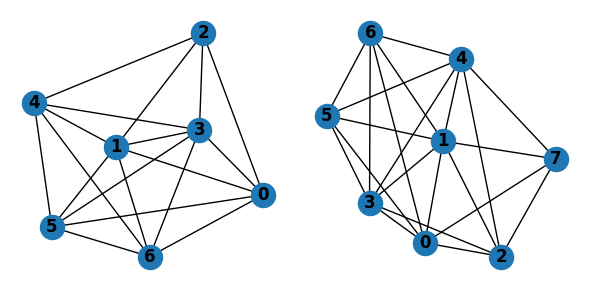

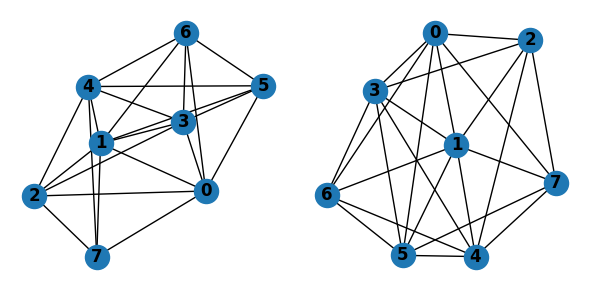

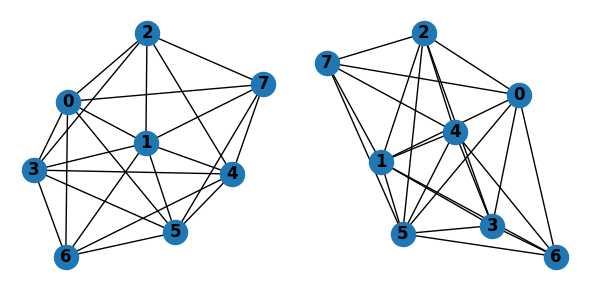

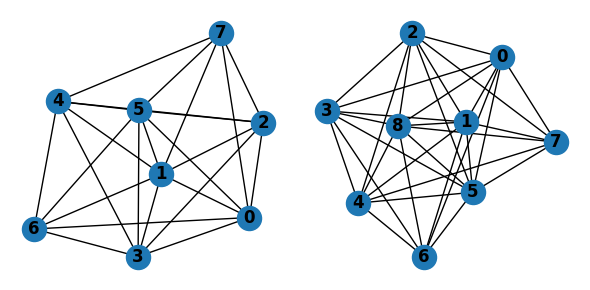

In [65]:
generator = RandomGraphGenerator()
start = generator.generate_random_ER_graph()

inc_consecutor = IncrementalConsecutor()
exc_consecutor = ConsecutorExecutor(inc_consecutor)

history = exc_consecutor.execute(start, steps=10)
hist_utils = HistoryUtilities()
hist_utils.assert_geds(history)

plot_cons_hist_entries(history, stop=5)

df = hist_utils.build_combinations_df(history)
df.to_json('./dataset/incremental.json', force_ascii=False, default_handler=vars, orient='records', lines=True)

### Decremental Dataset Generation Example

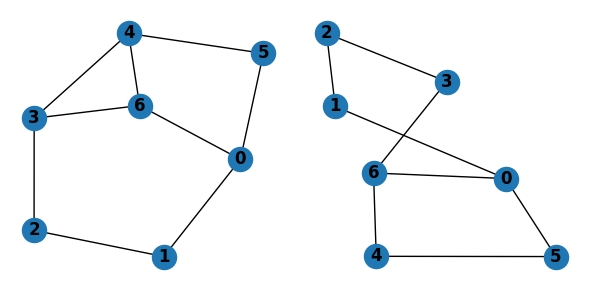

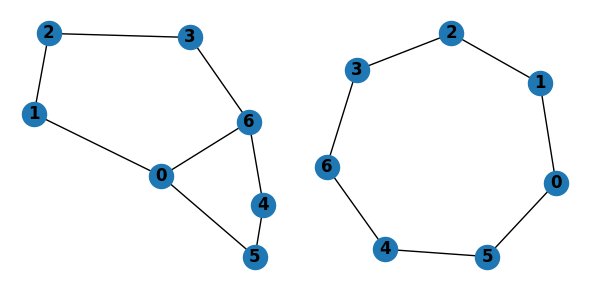

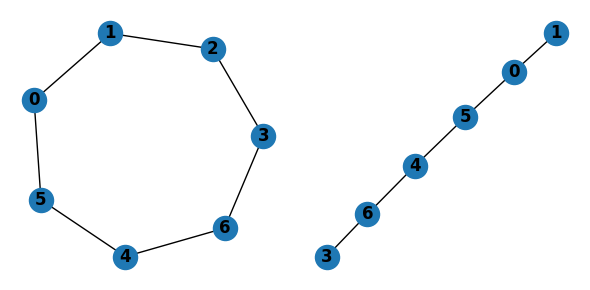

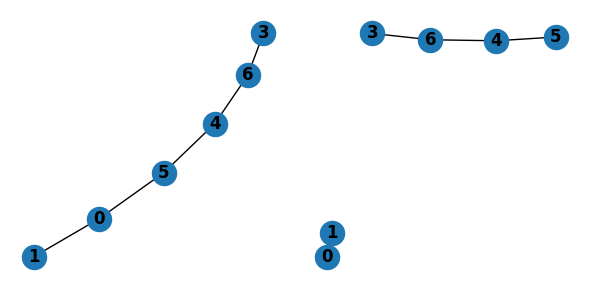

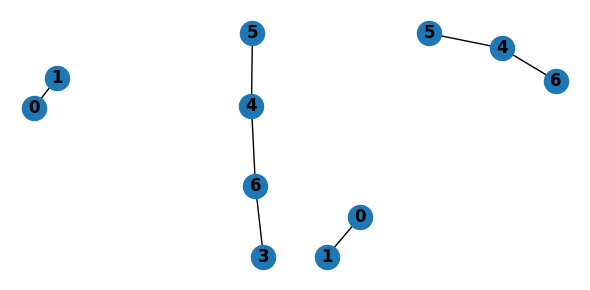

In [66]:
generator = RandomGraphGenerator()
start = generator.generate_random_ER_graph()

dec_consecutor = DecrementalConsecutor()
exc_consecutor = ConsecutorExecutor(dec_consecutor)

history = exc_consecutor.execute(start, steps=10)
hist_utils = HistoryUtilities()
hist_utils.assert_geds(history)

plot_cons_hist_entries(history, stop=5)

df = hist_utils.build_combinations_df(history)
df.to_json('./dataset/decremental.json', force_ascii=False, default_handler=vars, orient='records', lines=True)

## Reverse GEDs checks just to be sure

Altough GEDs are asserted in the previous steps, I initially faced a problem causing the stored data not to be consistent with real GEDs.
This was due to the fact that edge matrix are stored to the disk hence isolated nodes information was lost. Now that cannot happen anymore and the problem is solved.

In [67]:
import pandas as pd

def reverse_assert_ged(df : pd.DataFrame):
    g1s = df.graph_1.to_list()
    g2s = df.graph_2.to_list()
    geds = df.ged.to_list()

    for i in range(len(g1s)):
        G1 = nx.Graph(g1s[i])
        G2 = nx.Graph(g2s[i])
        ged = geds[i]
        rged = nx.graph_edit_distance(G1, G2)
        assert rged == ged

df_inc = pd.read_json('./dataset/incremental.json', orient='records', lines=True)
df_dec = pd.read_json('./dataset/decremental.json', orient='records', lines=True)
reverse_assert_ged(df_inc)
reverse_assert_ged(df_dec)